In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_classif

#Trzeba te labels dobrze dać
#15N 15H 15A 15N

In [2]:
import warnings
warnings.simplefilter("ignore")

# LOAD DATA

In [3]:
DATA_PATH = "BazaCut/"
FILIP_PATH = DATA_PATH + "sentencesFilip/"
SEB_PATH = DATA_PATH + "sentencesSebastian/"
MARCIN_PATH = DATA_PATH + "sentencesMarcin/"
PROF_PATH = DATA_PATH + "sentencesProfessor/"
no_of_sentences = 45
prefixes = ["F","S","M","L"]
Fs = 48000
sentences_filip = [i for i in range(no_of_sentences)]
sentences_seb = [i for i in range(no_of_sentences)]
sentences_marcin = [i for i in range(no_of_sentences)]
sentences_prof = [i for i in range(no_of_sentences)]

neutral = ["N"]*15
happy = ["H"] *15
anger = ["A"] *15
L = neutral+happy+anger


for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_F"+".wav"
    y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
    sentences_filip[i-1] = y

for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_S"+".wav"
    y, sr = librosa.load(SEB_PATH+file_name, sr=None)
    sentences_seb[i-1] = y

for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_M"+".wav"
    y, sr = librosa.load(MARCIN_PATH+file_name, sr=None)
    sentences_marcin[i-1] = y

for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_L"+".wav"
    y, sr = librosa.load(PROF_PATH+file_name, sr=None)
    sentences_prof[i-1] = y


# MFCC (Mel Frequency Cepstral Coefficients) and Deltta MFCC

In [4]:
# Ekstrakcja MFCC (np. 13 współczynników)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Dodatkowe cechy: delty MFCC
delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Połączenie cech w jedną macierz
features = np.concatenate([mfcc, delta_mfcc, delta2_mfcc], axis=0)

mfcc_features_no = 13
#Problem: w wyniku mfcc mamy macierz (13,x). Ilość kolumn dla każdego słowa jest inna. Nie da się 
#dać do numpy array
mfcc_filip = [i for i in range(no_of_sentences)]
mfcc_delta_filip = [i for i in range(no_of_sentences)]
mfcc_delta2_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_sentences)]
mfcc_delta_seb = [i for i in range(no_of_sentences)]
mfcc_delta2_seb = [i for i in range(no_of_sentences)]

for i, word in enumerate(sentences_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_sentences)]
mfcc_delta_marcin = [i for i in range(no_of_sentences)]
mfcc_delta2_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_sentences)]
mfcc_delta_prof = [i for i in range(no_of_sentences)]
mfcc_delta2_prof = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Using SVM

In [5]:
mfcc_filip_mean = np.zeros((no_of_sentences,mfcc_features_no))
mfcc_seb_mean = np.zeros((no_of_sentences,mfcc_features_no))
mfcc_marcin_mean= np.zeros((no_of_sentences,mfcc_features_no))
mfcc_prof_mean= np.zeros((no_of_sentences,mfcc_features_no))


for i in range(no_of_sentences):
    mfcc_filip_mean[i,0:mfcc_features_no] = np.mean(mfcc_filip[i],axis=1)
    mfcc_seb_mean[i,0:mfcc_features_no] = np.mean(mfcc_seb[i],axis=1)
    mfcc_marcin_mean[i,0:mfcc_features_no] = np.mean(mfcc_marcin[i],axis=1)
    mfcc_prof_mean[i,0:mfcc_features_no] = np.mean(mfcc_prof[i],axis=1)

feature_vector = np.concatenate((mfcc_filip_mean, mfcc_seb_mean,mfcc_marcin_mean,mfcc_prof_mean))



labelsN = np.zeros(15)
labelsH = np.zeros(15)+1
labelsA = np.zeros(15)+2
labels1 = np.concatenate((labelsN, labelsH,labelsA))
labels = np.concatenate((labels1, labels1,labels1,labels1))
feature_vector.shape

(180, 13)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.6, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7129629629629629
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        36
         1.0       0.71      0.67      0.69        36
         2.0       0.62      0.58      0.60        36

    accuracy                           0.71       108
   macro avg       0.71      0.71      0.71       108
weighted avg       0.71      0.71      0.71       108



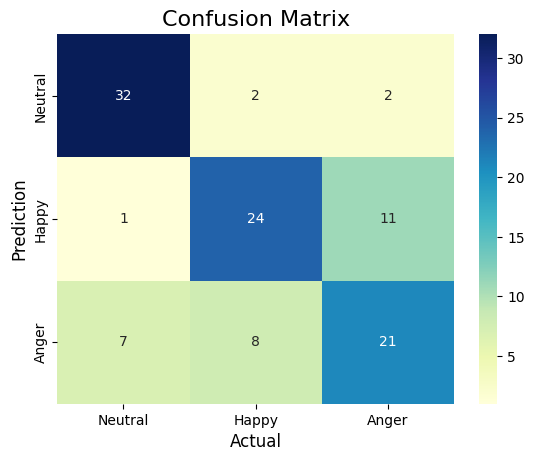

In [7]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [8]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7037037037037037
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86        36
         1.0       0.67      0.61      0.64        36
         2.0       0.59      0.61      0.60        36

    accuracy                           0.70       108
   macro avg       0.70      0.70      0.70       108
weighted avg       0.70      0.70      0.70       108



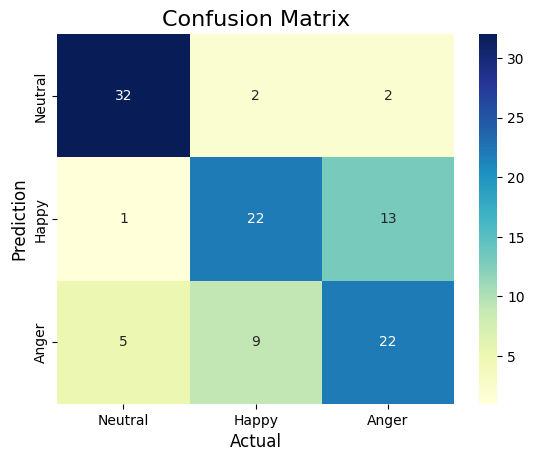

In [9]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [10]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
mlp_clf.fit(X_train, y_train)
mlp_pred = mlp_clf.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.8518518518518519
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93        36
         1.0       0.77      0.92      0.84        36
         2.0       0.89      0.69      0.78        36

    accuracy                           0.85       108
   macro avg       0.86      0.85      0.85       108
weighted avg       0.86      0.85      0.85       108



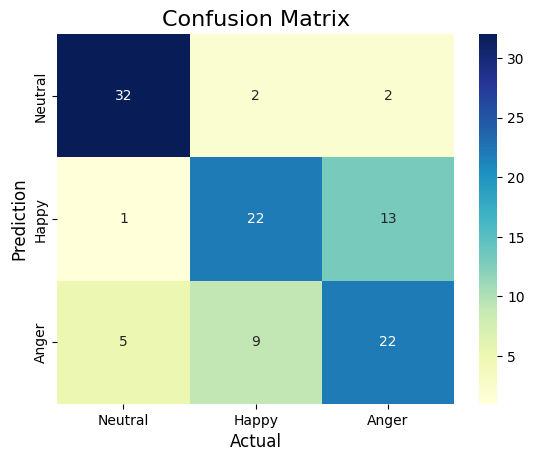

In [11]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Spectral Features
### Spectral Centroid, Spectral Bandwidth, Spectral Contrast, Spectral Flatness

In [12]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_seb):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_marcin[i] = spectral_features_vector

spectral_features_prof = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_prof[i] = spectral_features_vector


feature_vector = np.concatenate((spectral_features_filip, spectral_features_seb,spectral_features_marcin,spectral_features_prof))
feature_vector.shape

(180, 4)

# SVM

In [13]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.45555555555555555
              precision    recall  f1-score   support

         0.0       0.51      0.67      0.58        30
         1.0       0.44      0.12      0.19        33
         2.0       0.40      0.63      0.49        27

    accuracy                           0.46        90
   macro avg       0.45      0.47      0.42        90
weighted avg       0.46      0.46      0.41        90



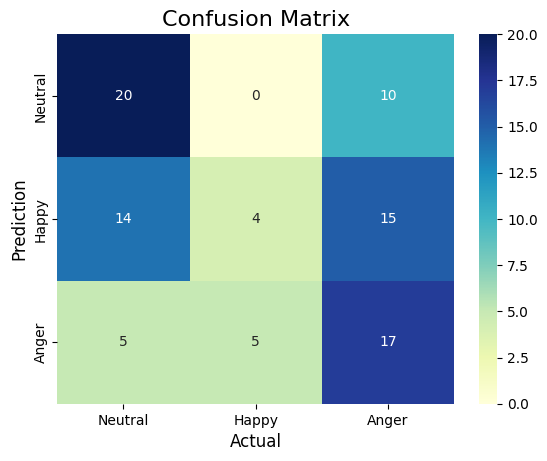

In [14]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [15]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4777777777777778
              precision    recall  f1-score   support

         0.0       0.61      0.57      0.59        30
         1.0       0.42      0.33      0.37        33
         2.0       0.42      0.56      0.48        27

    accuracy                           0.48        90
   macro avg       0.48      0.49      0.48        90
weighted avg       0.48      0.48      0.47        90



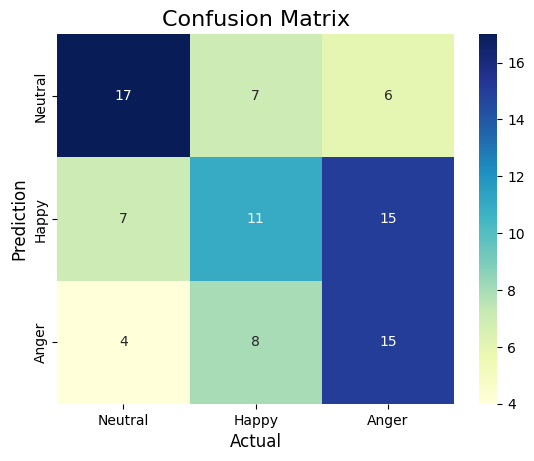

In [16]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [17]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)


mlp_pred = mlp_clf.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.5111111111111111
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.63      0.72        30
         1.0       0.43      0.39      0.41        33
         2.0       0.38      0.52      0.44        27

    accuracy                           0.51        90
   macro avg       0.55      0.52      0.52        90
weighted avg       0.55      0.51      0.52        90



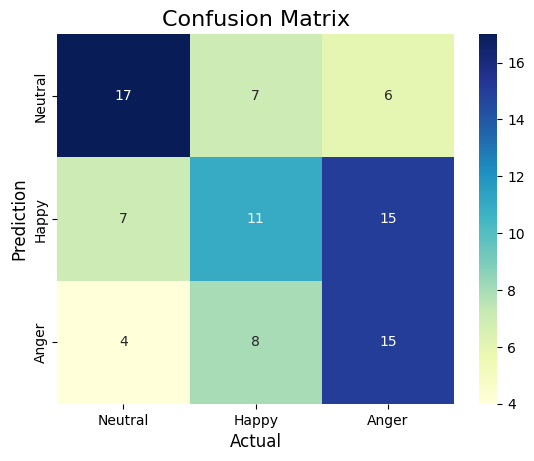

In [18]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Zero Crossing Rate

In [19]:
zcr_filip = [i for i in range(no_of_sentences)]
zcr_seb = [i for i in range(no_of_sentences)]
zcr_marcin = [i for i in range(no_of_sentences)]
zcr_prof = [i for i in range(no_of_sentences)]

for i, word in enumerate(sentences_filip):
    zcr_filip[i] = librosa.feature.zero_crossing_rate(y=word)[0]

for i, word in enumerate(sentences_seb):
    zcr_seb[i] = librosa.feature.zero_crossing_rate(y=word)[0]

for i, word in enumerate(sentences_marcin):
    zcr_marcin[i] = librosa.feature.zero_crossing_rate(y=word)[0]

for i, word in enumerate(sentences_prof):
    zcr_prof[i] = librosa.feature.zero_crossing_rate(y=word)[0]

#Czyli tamte wyżej są 2D z różną liczbą kolumn

zcr_filip_mean = np.zeros((no_of_sentences, 1))
zcr_seb_mean = np.zeros((no_of_sentences, 1))
zcr_marcin_mean = np.zeros((no_of_sentences, 1))
zcr_prof_mean = np.zeros((no_of_sentences, 1))

for i in range(no_of_sentences):
    zcr_filip_mean[i, 0] = np.mean(zcr_filip[i])
    zcr_seb_mean[i, 0] = np.mean(zcr_seb[i])
    zcr_marcin_mean[i, 0] = np.mean(zcr_marcin[i])
    zcr_prof_mean[i, 0] = np.mean(zcr_prof[i])


feature_vector_zeros = np.concatenate((zcr_filip_mean, zcr_seb_mean, zcr_marcin_mean, zcr_prof_mean))

X_train, X_test, y_train, y_test = train_test_split(feature_vector_zeros, labels, test_size=0.5, random_state=44)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM

SVM Accuracy: 0.36666666666666664
              precision    recall  f1-score   support

         0.0       0.40      0.75      0.53        28
         1.0       0.32      0.40      0.35        30
         2.0       1.00      0.00      0.00        32

    accuracy                           0.37        90
   macro avg       0.57      0.38      0.29        90
weighted avg       0.59      0.37      0.28        90



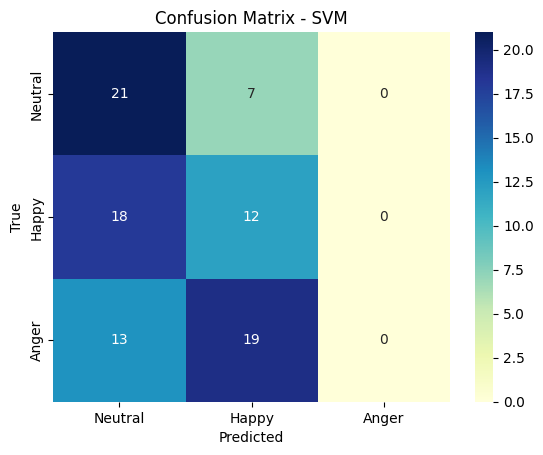

In [20]:
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=1))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Neutral", "Happy", "Anger"], yticklabels=["Neutral", "Happy", "Anger"])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Random Forest

Random Forest Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.26      0.36      0.30        28
         1.0       0.44      0.27      0.33        30
         2.0       0.35      0.38      0.36        32

    accuracy                           0.33        90
   macro avg       0.35      0.33      0.33        90
weighted avg       0.36      0.33      0.33        90



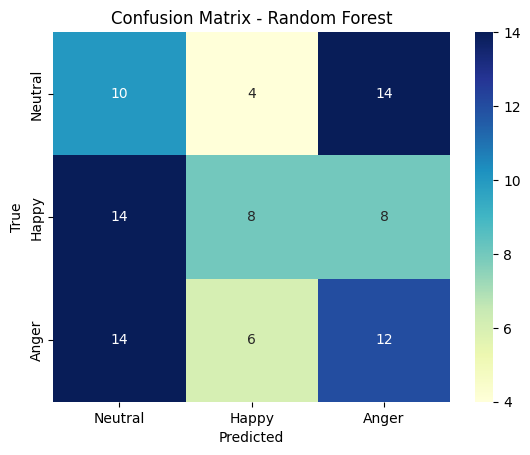

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=1))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Neutral", "Happy", "Anger"], yticklabels=["Neutral", "Happy", "Anger"])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# MPL

MLP Accuracy: 0.23333333333333334
              precision    recall  f1-score   support

         0.0       0.21      0.29      0.24        28
         1.0       0.35      0.23      0.28        30
         2.0       0.19      0.19      0.19        32

    accuracy                           0.23        90
   macro avg       0.25      0.24      0.24        90
weighted avg       0.25      0.23      0.24        90



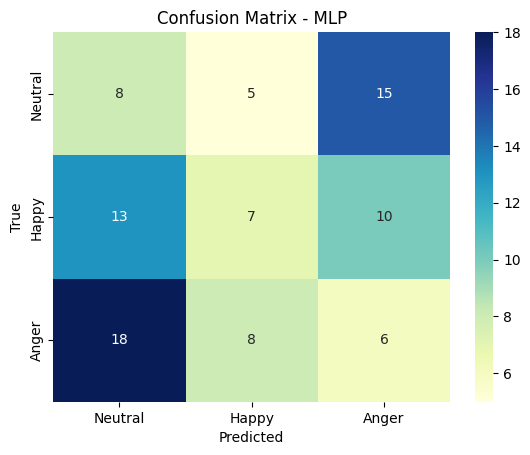

In [22]:

mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp, zero_division=1))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Neutral", "Happy", "Anger"], yticklabels=["Neutral", "Happy", "Anger"])
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Chroma features

In [23]:
def get_chroma_features(data, chroma_types):
    chroma_stft = []
    chroma_cqt = []
    chroma_cens = []
    chroma_vqt = []


    for audio in data:
        word_stft = chroma_types[list(chroma_types.keys())[0]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[0]]["params"])
        word_cqt = chroma_types[list(chroma_types.keys())[1]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[1]]["params"])
        word_cens = chroma_types[list(chroma_types.keys())[2]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[2]]["params"])
        word_vqt = chroma_types[list(chroma_types.keys())[3]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[3]]["params"])


        chroma_stft.append(word_stft)
        chroma_cqt.append(word_cqt)
        chroma_cens.append(word_cens)
        chroma_vqt.append(word_vqt)

    return chroma_stft, chroma_cqt, chroma_cens, chroma_vqt


def get_mean_chroma_features(data, chroma_types):

    chroma_stft = []
    chroma_cqt = []
    chroma_cens = []
    chroma_vqt = []


    for audio in data:
        word_stft = chroma_types[list(chroma_types.keys())[0]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[0]]["params"])
        word_cqt = chroma_types[list(chroma_types.keys())[1]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[1]]["params"])
        word_cens = chroma_types[list(chroma_types.keys())[2]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[2]]["params"])
        word_vqt = chroma_types[list(chroma_types.keys())[3]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[3]]["params"])


        chroma_stft.append(word_stft.mean(axis=1).flatten())
        chroma_cqt.append(word_cqt.mean(axis=1).flatten())
        chroma_cens.append(word_cens.mean(axis=1).flatten())
        chroma_vqt.append(word_vqt.mean(axis=1).flatten())

    return chroma_stft, chroma_cqt, chroma_cens, chroma_vqt

In [24]:
chroma_types ={
    "stft": {
        "func": librosa.feature.chroma_stft,
        "params": {},
    },
    "cqt": {
        "func": librosa.feature.chroma_cqt,
        "params": {},
    },
    "cens": {
        "func": librosa.feature.chroma_cens,
        "params": {},
    },
    "vqt": {
        "func": librosa.feature.chroma_vqt,
        "params": {"intervals": "equal"},
    }
}

chroma_filip_stft_mean, chroma_filip_cqt_mean, chroma_filip_cens_mean, chroma_filip_vqt_mean = get_mean_chroma_features(sentences_filip, chroma_types)
chroma_seb_stft_mean, chroma_seb_cqt_mean, chroma_seb_cens_mean, chroma_seb_vqt_mean = get_mean_chroma_features(sentences_seb, chroma_types)
chroma_marcin_stft_mean, chroma_marcin_cqt_mean, chroma_marcin_cens_mean, chroma_marcin_vqt_mean = get_mean_chroma_features(sentences_marcin, chroma_types)
chroma_prof_stft_mean, chroma_prof_cqt_mean, chroma_prof_cens_mean, chroma_prof_vqt_mean = get_mean_chroma_features(sentences_prof, chroma_types)


In [25]:
chroma_filip = np.concatenate((np.array(chroma_filip_stft_mean),np.array(chroma_filip_cqt_mean),np.array(chroma_filip_cens_mean),np.array(chroma_filip_vqt_mean)),axis=1)
chroma_seb = np.concatenate((np.array(chroma_seb_stft_mean),np.array(chroma_seb_cqt_mean),np.array(chroma_seb_cens_mean),np.array(chroma_seb_vqt_mean)),axis=1)
chroma_marcin = np.concatenate((np.array(chroma_marcin_stft_mean),np.array(chroma_marcin_cqt_mean),np.array(chroma_marcin_cens_mean),np.array(chroma_marcin_vqt_mean)),axis=1)
chroma_prof = np.concatenate((np.array(chroma_prof_stft_mean),np.array(chroma_prof_cqt_mean),np.array(chroma_prof_cens_mean),np.array(chroma_prof_vqt_mean)),axis=1)

feature_vector_chroma = np.concatenate((chroma_filip, chroma_seb,chroma_marcin,chroma_prof))

X_train, X_test, y_train, y_test = train_test_split(feature_vector_chroma, labels, test_size=0.5, random_state=44)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM

SVM Accuracy: 0.4888888888888889
              precision    recall  f1-score   support

         0.0       0.47      0.68      0.56        28
         1.0       0.54      0.50      0.52        30
         2.0       0.45      0.31      0.37        32

    accuracy                           0.49        90
   macro avg       0.49      0.50      0.48        90
weighted avg       0.49      0.49      0.48        90



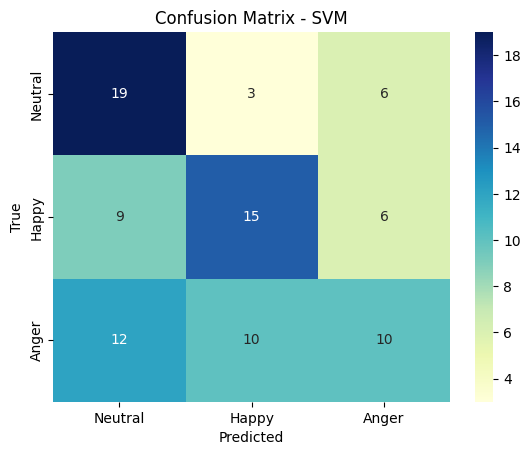

In [26]:
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=1))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Neutral", "Happy", "Anger"], yticklabels=["Neutral", "Happy", "Anger"])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Random Forest

Random Forest Accuracy: 0.5888888888888889
              precision    recall  f1-score   support

         0.0       0.54      0.79      0.64        28
         1.0       0.69      0.60      0.64        30
         2.0       0.57      0.41      0.47        32

    accuracy                           0.59        90
   macro avg       0.60      0.60      0.58        90
weighted avg       0.60      0.59      0.58        90



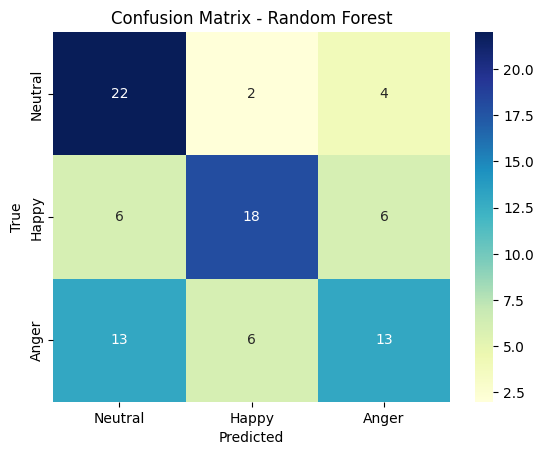

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=1))

cm_rf = confusion_matrix(y_test, y_pred_rf)
ticks = ["Neutral", "Happy", "Anger"]

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# MLP

MLP Accuracy: 0.6111111111111112
              precision    recall  f1-score   support

         0.0       0.57      0.71      0.63        28
         1.0       0.78      0.70      0.74        30
         2.0       0.50      0.44      0.47        32

    accuracy                           0.61        90
   macro avg       0.62      0.62      0.61        90
weighted avg       0.61      0.61      0.61        90



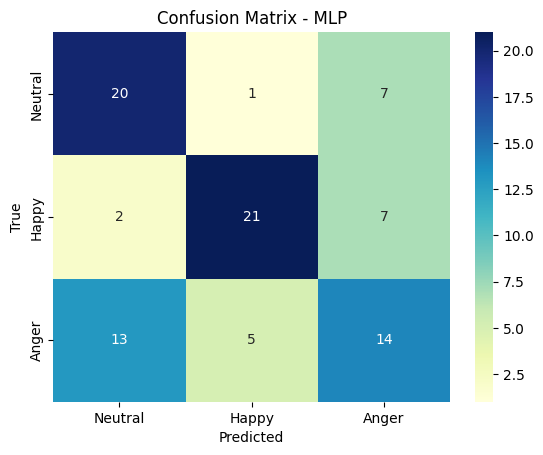

In [28]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp, zero_division=1))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
ticks = ["Neutral", "Happy", "Anger"]

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='YlGnBu', xticklabels=ticks, yticklabels=ticks)
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Select
## Do wybrania najelpszeych cech użyto SelectKBest - wybranie najlepszych k cech na podstawie danego krytetrium

In [29]:
#Funckja do spłaszczania tablicy 3d do 2d. Robi flatten na ostatnich dwóch wymiarach
def flatten_features(data,X,Y,Z):

    mfcc_cut = np.zeros((X,Y,Z))
    mfcc_final = np.zeros((X,Y*Z))

    for i in range(X):
        for j in range(Y):
            mfcc_cut[i][j] =  data[i][j][:Z]

        to_flatten =  mfcc_cut[i]
        mfcc_final[i] = to_flatten.flatten()
    return mfcc_final

labelsN = np.zeros(15)
labelsH = np.zeros(15)+1
labelsA = np.zeros(15)+2
labels1 = np.concatenate((labelsN, labelsH,labelsA))
labels_names = np.concatenate((labels1, labels1,labels1,labels1))

## MFCC

In [30]:
mfcc_features_no = 13
mfcc_filip = [i for i in range(no_of_sentences)]
mfcc_delta_filip = [i for i in range(no_of_sentences)]
mfcc_delta2_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_sentences)]
mfcc_delta_seb = [i for i in range(no_of_sentences)]
mfcc_delta2_seb = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_sentences)]
mfcc_delta_marcin = [i for i in range(no_of_sentences)]
mfcc_delta2_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_sentences)]
mfcc_delta_prof = [i for i in range(no_of_sentences)]
mfcc_delta2_prof = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Macierze mfcc mają wymiar (30,13,x), gdzie x ma różną długość dla każdego słowwa.
# Może obciąż wszystkie dla najmniejszej długości
# to może ograniczyć i zrobić flatten
least_to_take = 200

mfcc_filip_final = flatten_features(mfcc_filip, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_seb_final = flatten_features(mfcc_seb, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_marcin_final = flatten_features(mfcc_marcin, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_prof_final = flatten_features(mfcc_prof, no_of_sentences, mfcc_features_no,least_to_take)


mfcc_delta_filip_final = flatten_features(mfcc_delta_filip, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta_seb_final = flatten_features(mfcc_delta_seb, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta_marcin_final = flatten_features(mfcc_delta_marcin, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta_prof_final = flatten_features(mfcc_delta_prof, no_of_sentences, mfcc_features_no,least_to_take)

mfcc_delta2_filip_final = flatten_features(mfcc_delta2_filip, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta2_seb_final = flatten_features(mfcc_delta2_seb, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta2_marcin_final = flatten_features(mfcc_delta2_marcin, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta2_prof_final = flatten_features(mfcc_delta2_prof, no_of_sentences, mfcc_features_no,least_to_take)





feature_vector_mfcc = np.concatenate((mfcc_filip_final, mfcc_seb_final,mfcc_marcin_final,mfcc_prof_final))
feature_vector_mfcc_delta = np.concatenate((mfcc_delta_filip_final, mfcc_delta_seb_final,mfcc_delta_marcin_final,mfcc_delta_prof_final))
feature_vector_mfcc_delta2 = np.concatenate((mfcc_delta2_filip_final, mfcc_delta2_seb_final,mfcc_delta2_marcin_final,mfcc_delta2_prof_final))

feature_vector_mfcc = np.concatenate((feature_vector_mfcc, feature_vector_mfcc_delta,feature_vector_mfcc_delta2), axis=1)

print(feature_vector_mfcc.shape)

(180, 7800)


## Przykład użycia SelectKBest

In [31]:
def get_bar_plot(data, labels, title):
    plt.bar(labels, data)
    plt.title(title)
    plt.xlabel('number of features')
    plt.ylabel('Accuracy')
    plt.show()

# SVM 

[0.5, 0.4722222222222222, 0.5555555555555556, 0.5833333333333334, 0.6111111111111112, 0.6111111111111112, 0.5833333333333334, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556]


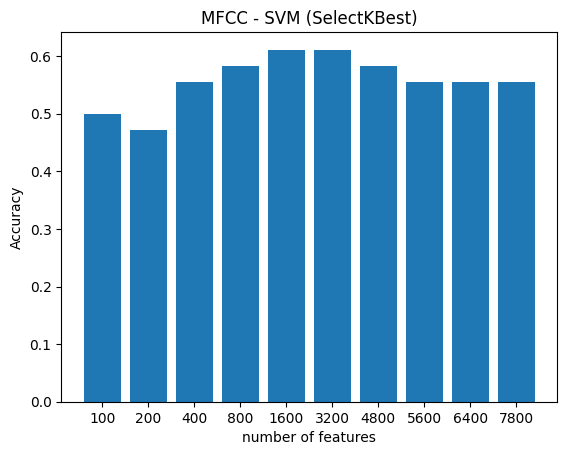

In [32]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_mfcc, labels_names, test_size=0.2, random_state=42)
# Tutaj jest aż 7800 cech
how_many_features = [100, 200, 400, 800, 1600, 3200, 4800, 5600, 6400,7800]
accuracies_mfcc = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_mfcc.append(accuracy_score(y_test, y_pred))

print(accuracies_mfcc)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_mfcc, labels, "MFCC - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Random Forest

[0.4722222222222222, 0.6388888888888888, 0.6944444444444444, 0.6388888888888888, 0.6111111111111112, 0.6111111111111112, 0.6388888888888888, 0.5555555555555556, 0.5833333333333334, 0.4722222222222222]


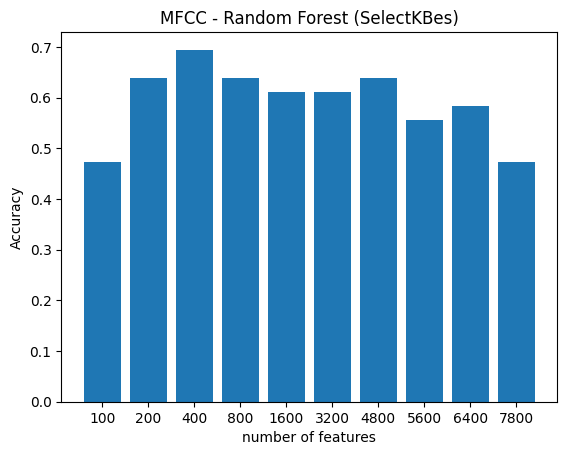

In [33]:
accuracies_mfcc = []

for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_mfcc.append(accuracy_score(y_test, y_pred))
    
print(accuracies_mfcc)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_mfcc, labels, "MFCC - Random Forest (SelectKBes)")

## MLP

[0.5, 0.5, 0.6388888888888888, 0.6111111111111112, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6111111111111112]


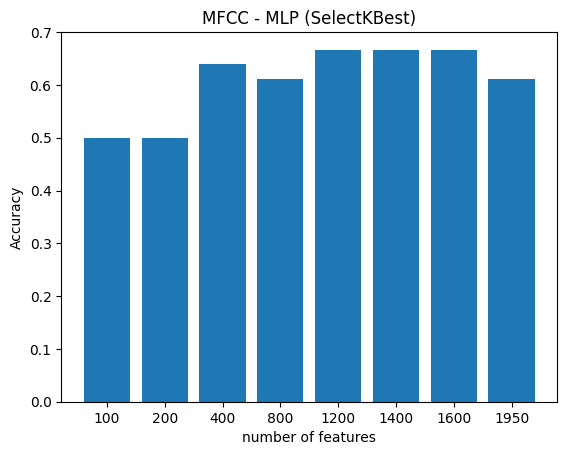

In [34]:
how_many_features = [100, 200, 400, 800, 1200, 1400, 1600, 1950]
accuracies_mfcc = []


for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)
    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_mfcc.append(accuracy_score(y_test, y_pred))
print(accuracies_mfcc)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_mfcc, labels, "MFCC - MLP (SelectKBest)")

## Spectral

In [35]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_seb):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_marcin[i] = spectral_features_vector

spectral_features_prof= [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_prof[i] = spectral_features_vector


least_to_take = 200

spectral_filip_final = flatten_features(spectral_features_filip, no_of_sentences, 10, least_to_take)
spectral_seb_final = flatten_features(spectral_features_seb, no_of_sentences, 10, least_to_take)
spectral_marcin_final = flatten_features(spectral_features_marcin, no_of_sentences, 10, least_to_take)
spectral_prof_final = flatten_features(spectral_features_prof, no_of_sentences, 10, least_to_take)

feature_vector_spec = np.concatenate((spectral_filip_final, spectral_seb_final,spectral_marcin_final,spectral_prof_final))
print(feature_vector_spec.shape)

(180, 2000)


# SVM

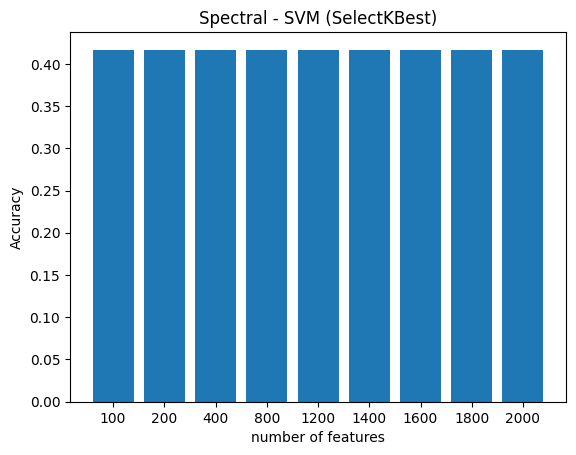

In [36]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_spec, labels_names, test_size=0.2, random_state=42)
#Tu jest 2000 cech
how_many_features = [100,200,400,800,1200,1400,1600,1800,2000]
accuracies_spectral = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=400)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_spectral.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_spectral, labels, "Spectral - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Random Forest

[0.5, 0.4166666666666667, 0.4444444444444444, 0.4166666666666667, 0.3055555555555556, 0.4722222222222222, 0.3888888888888889, 0.4166666666666667, 0.3888888888888889]


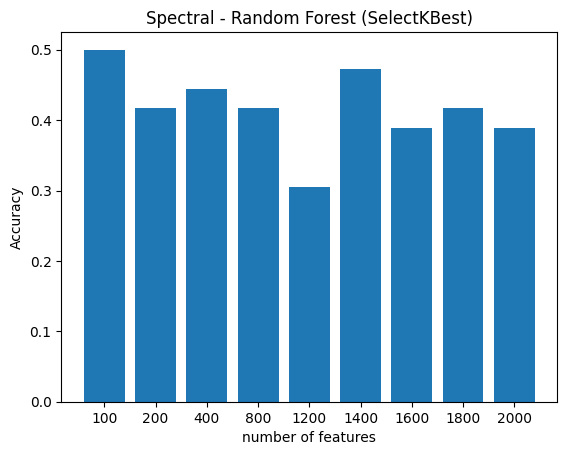

In [37]:
accuracies_spectral = []

for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_spectral.append(accuracy_score(y_test, y_pred))
    
print(accuracies_spectral)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_spectral, labels, "Spectral - Random Forest (SelectKBest)")

## MLP

[0.4444444444444444, 0.4444444444444444, 0.4722222222222222, 0.4444444444444444, 0.5555555555555556, 0.5, 0.5833333333333334, 0.4722222222222222, 0.5555555555555556]


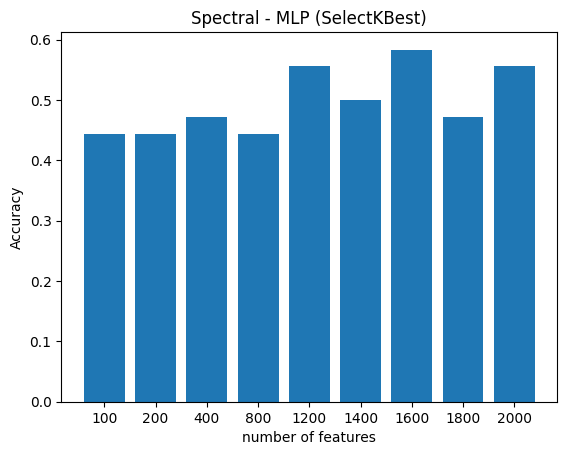

In [38]:
accuracies_spectral = []


for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)
    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_spectral.append(accuracy_score(y_test, y_pred))
print(accuracies_spectral)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_spectral, labels, "Spectral - MLP (SelectKBest)")

# Zero Crossing Rate

In [39]:
to_take = 50
for i in range(len(zcr_filip)):
    zcr_filip[i] = zcr_filip[i][:to_take]
    zcr_seb[i] = zcr_seb[i][:to_take]
    zcr_marcin[i] = zcr_marcin[i][:to_take]
    zcr_prof[i] = zcr_prof[i][:to_take]

zcr_filip = np.array(zcr_filip)
zcr_seb = np.array(zcr_seb)
zcr_marcin = np.array(zcr_marcin)
zcr_prof = np.array(zcr_prof)

feature_vector_zeros = np.concatenate((zcr_filip, zcr_seb,zcr_marcin,zcr_prof))
feature_vector_zeros.shape

(180, 50)

## SVM

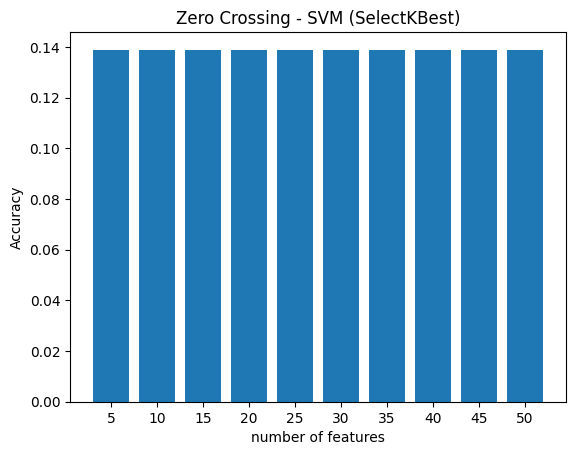

In [40]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_zeros, labels_names, test_size=0.2, random_state=42)
how_many_features = [5,10,15,20,25,30,35,40,45,50]
accuracies_zcr = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=50)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_zcr.append(accuracy_score(y_test, y_pred))
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_zcr, labels, "Zero Crossing - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Random Forest

[0.3333333333333333, 0.25, 0.2777777777777778, 0.3611111111111111, 0.25, 0.2777777777777778, 0.3055555555555556, 0.3333333333333333, 0.4166666666666667, 0.4166666666666667]


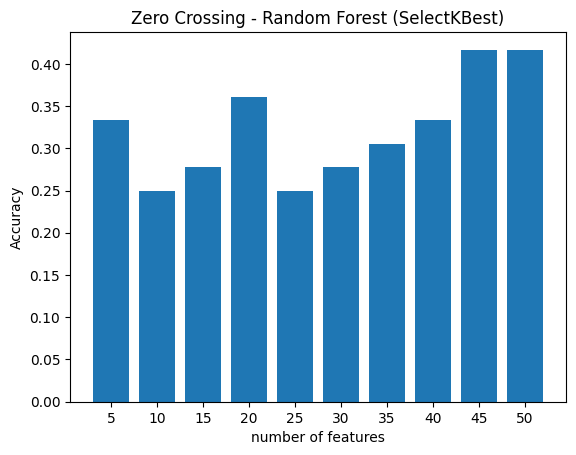

In [41]:
accuracies_zcr = []

for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_zcr.append(accuracy_score(y_test, y_pred))
    
print(accuracies_zcr)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_zcr, labels, "Zero Crossing - Random Forest (SelectKBest)")

## MLP

[0.2777777777777778, 0.3611111111111111, 0.3333333333333333, 0.3055555555555556, 0.3611111111111111, 0.19444444444444445, 0.2777777777777778, 0.25, 0.3055555555555556, 0.2777777777777778]


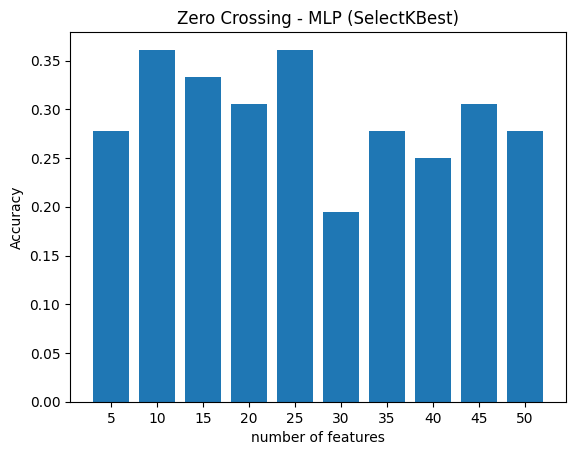

In [42]:
accuracies_zcr = []


for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)


    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)
    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_zcr.append(accuracy_score(y_test, y_pred))
print(accuracies_zcr)
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_zcr, labels, "Zero Crossing - MLP (SelectKBest)")

# Chroma

In [43]:
chroma_filip_stft, chroma_filip_cqt, chroma_filip_cens, chroma_filip_vqt = get_chroma_features(sentences_filip, chroma_types)
chroma_seb_stft, chroma_seb_cqt, chroma_seb_cens, chroma_seb_vqt = get_chroma_features(sentences_seb, chroma_types)
chroma_marcin_stft, chroma_marcin_cqt, chroma_marcin_cens, chroma_marcin_vqt = get_chroma_features(sentences_marcin, chroma_types)
chroma_prof_stft, chroma_prof_cqt, chroma_prof_cens, chroma_prof_vqt = get_chroma_features(sentences_prof, chroma_types)

In [44]:
least_to_take = 50

chroma_filip_stft_final = flatten_features(chroma_filip_stft, no_of_sentences, 12, least_to_take)
chroma_filip_cqt_final  = flatten_features(chroma_filip_cqt, no_of_sentences, 12, least_to_take)
chroma_filip_cens_final  = flatten_features(chroma_filip_cens, no_of_sentences, 12, least_to_take)
chroma_filip_vqt_final  = flatten_features(chroma_filip_vqt, no_of_sentences, 12, least_to_take)

chroma_filip_final = np.concatenate((chroma_filip_stft_final, chroma_filip_cqt_final,chroma_filip_cens_final,chroma_filip_vqt_final),axis=1)

chroma_seb_stft_final = flatten_features(chroma_seb_stft, no_of_sentences, 12, least_to_take)
chroma_seb_cqt_final  = flatten_features(chroma_seb_cqt, no_of_sentences, 12, least_to_take)
chroma_seb_cens_final  = flatten_features(chroma_seb_cens, no_of_sentences, 12, least_to_take)
chroma_seb_vqt_final  = flatten_features(chroma_seb_vqt, no_of_sentences, 12, least_to_take)

chroma_seb_final = np.concatenate((chroma_seb_stft_final, chroma_seb_cqt_final,chroma_seb_cens_final,chroma_seb_vqt_final),axis=1)

chroma_marcin_stft_final = flatten_features(chroma_marcin_stft, no_of_sentences, 12, least_to_take)
chroma_marcin_cqt_final  = flatten_features(chroma_marcin_cqt, no_of_sentences, 12, least_to_take)
chroma_marcin_cens_final  = flatten_features(chroma_marcin_cens, no_of_sentences, 12, least_to_take)
chroma_marcin_vqt_final  = flatten_features(chroma_marcin_vqt, no_of_sentences, 12, least_to_take)

chroma_marcin_final = np.concatenate((chroma_marcin_stft_final, chroma_marcin_cqt_final,chroma_marcin_cens_final,chroma_marcin_vqt_final),axis=1)

chroma_prof_stft_final = flatten_features(chroma_prof_stft, no_of_sentences, 12, least_to_take)
chroma_prof_cqt_final  = flatten_features(chroma_prof_cqt, no_of_sentences, 12, least_to_take)
chroma_prof_cens_final  = flatten_features(chroma_prof_cens, no_of_sentences, 12, least_to_take)
chroma_prof_vqt_final  = flatten_features(chroma_prof_vqt, no_of_sentences, 12, least_to_take)

chroma_prof_final = np.concatenate((chroma_prof_stft_final, chroma_prof_cqt_final,chroma_prof_cens_final,chroma_prof_vqt_final),axis=1)


feature_vector_chroma = np.concatenate((chroma_filip_final, chroma_seb_final,chroma_marcin_final,chroma_prof_final))
print(feature_vector_chroma.shape)

(180, 2400)


## SVM

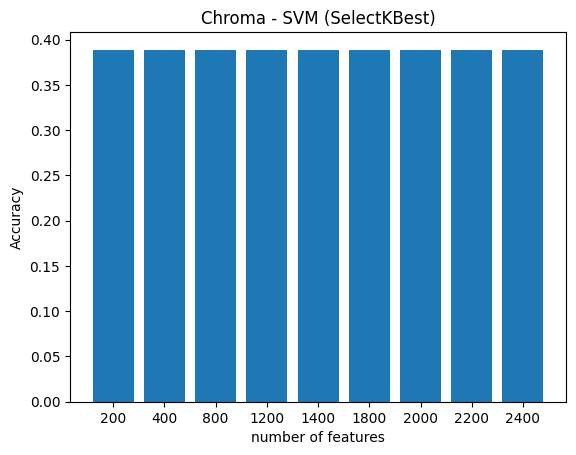

In [45]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_chroma, labels_names, test_size=0.2, random_state=42)
# Jest 2400 cech
how_many_features = [200,400,800,1200,1400,1800,2000,2200,2400]

accuracies_chroma = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=400)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_chroma.append(accuracy_score(y_test, y_pred))
    
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_chroma, labels, "Chroma - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Random Forest

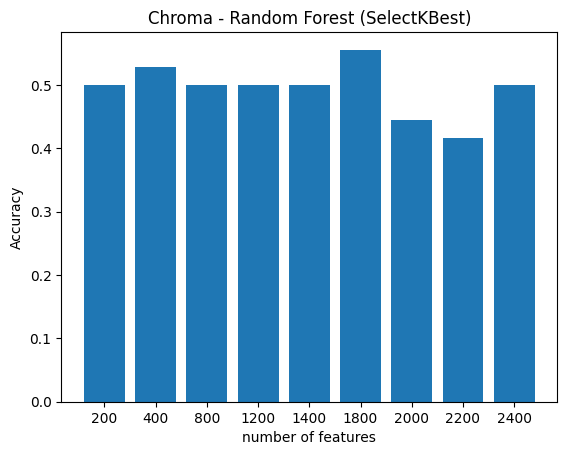

In [46]:
accuracies_chroma = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies_chroma.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_chroma, labels, "Chroma - Random Forest (SelectKBest)")

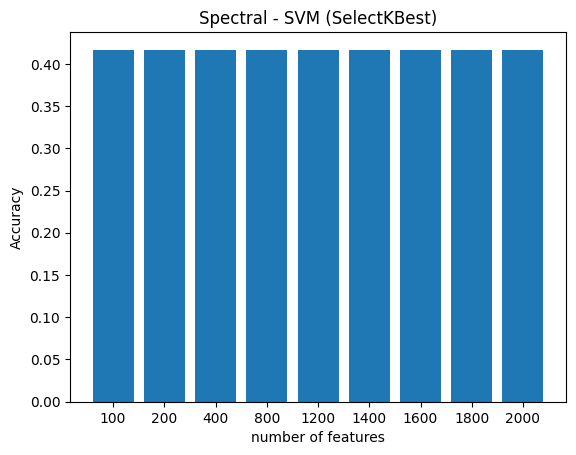

In [47]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_spec, labels_names, test_size=0.2, random_state=42)
#Tu jest 2000 cech
how_many_features = [100,200,400,800,1200,1400,1600,1800,2000]
accuracies_spectral = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=400)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies_spectral.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_spectral, labels, "Spectral - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## MLP

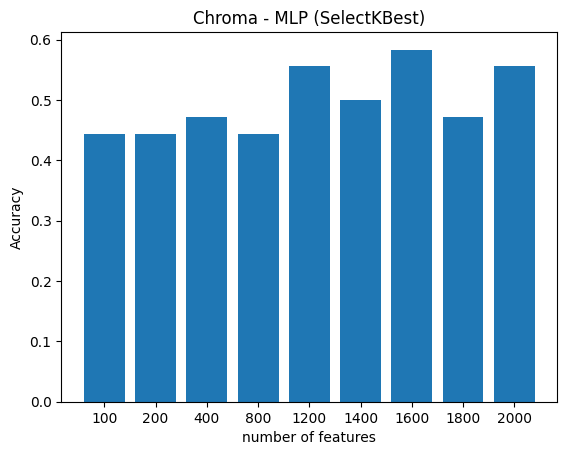

In [48]:
accuracies_chroma = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)

    y_pred = mlp_clf.predict(X_test_selected)
    accuracies_chroma.append(accuracy_score(y_test, y_pred))
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies_chroma, labels, "Chroma - MLP (SelectKBest)")

# Połączenie MFCC i Spectral i zero crossing i chroma

## SVM

(180, 12250)


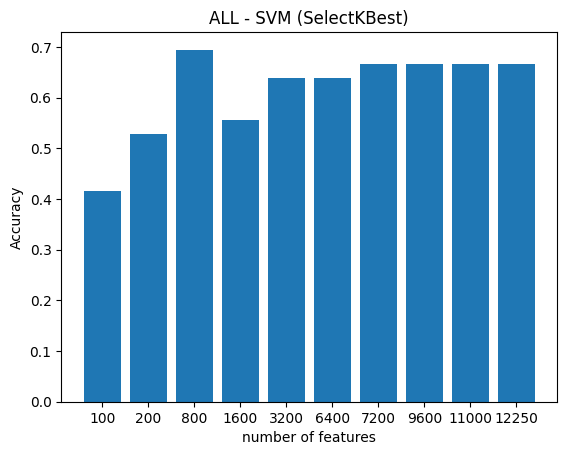

In [49]:
feature_vector = np.concatenate((feature_vector_mfcc, feature_vector_spec,feature_vector_zeros,feature_vector_chroma), axis=1)
print(feature_vector.shape)
# Jest aż 12250 cech
how_many_features = [100,200,800,1600,3200,6400,7200,9600,11000,12250]



accuracies = []
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels_names, test_size=0.2, random_state=42)
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    svm = SVC(kernel='linear', C=1.0, random_state=42)
    svm.fit(X_train_selected, y_train)
    y_pred = svm.predict(X_test_selected)
    accuracies.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies, labels, "ALL - SVM (SelectKBest)")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Random Forest

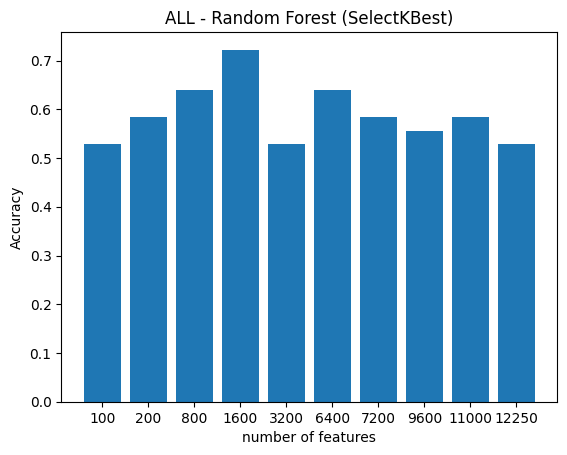

In [50]:
accuracies = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    rbf = RandomForestClassifier(n_estimators=100, random_state=42)
    rbf.fit(X_train_selected, y_train)
    y_pred = rbf.predict(X_test_selected)
    accuracies.append(accuracy_score(y_test, y_pred))

labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies, labels, "ALL - Random Forest (SelectKBest)")

## MLP

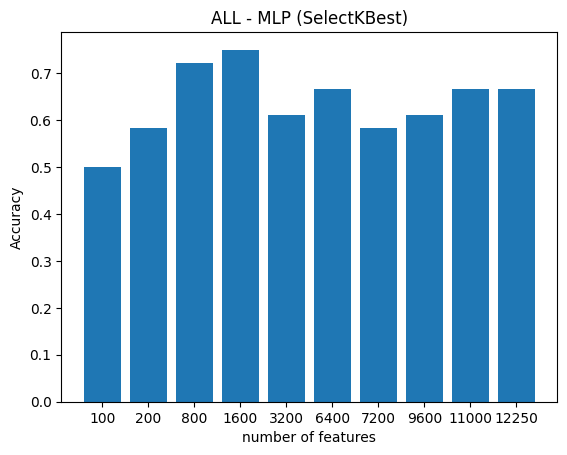

In [51]:
accuracies = []
for how_many in how_many_features:
    selector = SelectKBest(score_func=f_classif, k=how_many)  
    X_train_selected = selector.fit_transform(X_train, y_train)  
    X_test_selected = selector.transform(X_test)  

    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)

    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
    mlp_clf.fit(X_train_selected, y_train)

    y_pred = mlp_clf.predict(X_test_selected)
    accuracies.append(accuracy_score(y_test, y_pred))
labels = [str(i) for i in how_many_features]
get_bar_plot(accuracies, labels, "ALL - MLP (SelectKBest)")